In [1]:
import dataset_handler as dh
import testing_utils as tu
from termcolor import colored
import re

/home/CodeGen_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
priming_text_path = "data/priming_texts/gsm8k/codegen/func_eq_short.txt"
gsm8k_path = "data/grade-school-math/grade_school_math/data/train.jsonl"

current_dataset = dh.init_dataset_from_name(
        "gsm8k", primingtext_path=priming_text_path
    )

In [4]:
subset_data = current_dataset.data[:3000]

subset_data = [elem["question"] for elem in subset_data]

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

tu.set_all_seeds("codegen")

embedder = SentenceTransformer('all-mpnet-base-v2')

# Corpus with example sentences
corpus = subset_data
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 4
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[0])
    print("")

Cluster  1
Mark has a garden with flowers. He planted plants of three different colors in it. Ten of them are yellow, and there are 80% more of those in purple. There are only 25% as many green flowers as there are yellow and purple flowers. How many flowers does Mark have in his garden?

Cluster  2
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Cluster  3
Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?

Cluster  4
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?



In [6]:
#save to a pickle the clsutering model
import pickle
with open("clustering_model.pkl", "wb") as f:
    pickle.dump(clustering_model, f)

In [45]:
def print_colored_pos(dist_list, pos):
    for i, dist in enumerate(dist_list):
        if i == pos:
            print(colored(dist, "cyan"))

In [46]:
def extract_eq(full_answer):
    eq_pattern = re.compile(r"<<([^>]+)>>")
    split_list = re.findall(eq_pattern, full_answer)

    eq_string = ""

    for i, eq in enumerate(split_list):
        eq_string += f" eq{i+1}: {eq}"

    return eq_string

In [53]:
import numpy as np
def print_cluster_closest(cluster_id):
    d = clustering_model.transform(corpus_embeddings)[:, cluster_id]
    ind = np.argsort(d)[::][:3]
    print(list(ind))
    for ex_i,i in enumerate(ind):
        #print_colored_pos(clustering_model.transform([corpus_embeddings[i]])[0], 1)
        print( f"def exercise{ex_i+1}():\n"
            + '    """'
            + current_dataset.data[i]["question"]
            + " Hint: use these equations"
            + extract_eq(current_dataset.data[i]["answer"])
            + '"""')
        print("\n")
        current_dataset.print_entry_from_idx(i)

In [54]:
print_cluster_closest(0)

[2834, 447, 2092]
def exercise1():
    """The number of math problems that Marvin practiced today is three times as many as the number of problems he solved yesterday. His friend, Arvin, has practiced twice as many math problems on each day. How many math problems have they practiced altogether if Marvin solved 40 math problems yesterday? Hint: use these equations eq1: 40*3=120 eq2: 120+40=160 eq3: 160*2=320 eq4: 320+160=480"""


The number of math problems that Marvin practiced today is three times as many as the number of problems he solved yesterday. His friend, Arvin, has practiced twice as many math problems on each day. How many math problems have they practiced altogether if Marvin solved 40 math problems yesterday?
If Marvin solved 40 math problems yesterday, he has solved 40*3 = <<40*3=120>>120 math problems today.
The total number of math problems that Marvin has practiced is 120+40 = <<120+40=160>>160
Arvin has practiced twice as many as Marvin, so has practiced 160 * 2 = <<

In [43]:
from sklearn.decomposition import PCA

pca = PCA(2)

df = pca.fit_transform(corpus_embeddings)

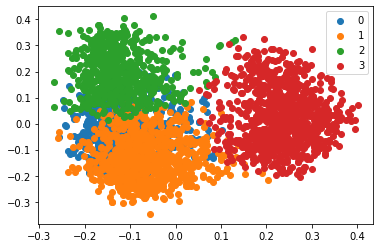

In [44]:
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters= 8, random_state=0)
 
#predict the labels of clusters.
#label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(cluster_assignment)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[cluster_assignment == i , 0] , df[cluster_assignment == i , 1] , label = i)
plt.legend()
plt.show()